This notebook is part of the $\omega radlib$ documentation: https://docs.wradlib.org.

Copyright (c) $\omega radlib$ developers.
Distributed under the MIT License. See LICENSE.txt for more info.

# Load ODIM_H5 Volume data from German Weather Service

In this example, we obtain and read the latest 2 hours of available volumetric radar data from German Weather Service available at [opendata.dwd.de](https://opendata.dwd.de). Finally we do some plotting.

This retrieves 24 timesteps of the 10 sweeps (moments DBZH and VRADH) of the DWD volume scan of a distinct radar. This amounts to 240 data files which are combined into one volumetric Cf/Radial2 like xarray powered structure.

Exports to single file Odim_H5 and Cf/Radial2 format are shown at the end of this tutorial.

<div class="alert alert-warning">

**Note** <br>

The used `open_odim` implementation is based on [netcdf4](https://unidata.github.io/netcdf4-python/), [h5py](https://www.h5py.org/), [h5netcdf](https://github.com/shoyer/h5netcdf) and [Xarray](http://xarray.pydata.org/en/stable/). It claims multiple data files and presents them in a simple structure. See also the notebook [wradlib_odim_multi_file_dataset](wradlib_odim_multi_file_dataset.ipynb) for further details.

</div>

In [1]:
import wradlib as wrl
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as pl
import numpy as np
import xarray as xr
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
from wradlib.io.xarray import open_odim, CfRadial   

In [2]:
import urllib3
import os
import io
import glob
import shutil
import datetime
from itertools import chain

## Download radar volumes of latest 2 hours from server using `wetterdienst`


`wetterdienst` is a neat package for easy retrieval of data primarily from DWD. For further information have a look at their [documentation](https://wetterdienst.readthedocs.io/).

In [3]:
from wetterdienst.dwd.radar import DWDRadarData, DWDRadarParameter, DWDRadarDate, DWDRadarDataFormat, DWDRadarDataSubset
from wetterdienst.dwd.radar.sites import DWDRadarSite

In [4]:
start_date = datetime.datetime.utcnow()

# Horizontal Doppler Velocity
request_velocity = DWDRadarData(
    parameter=DWDRadarParameter.SWEEP_VOL_VELOCITY_H,
    start_date=start_date - datetime.timedelta(hours=2),
    end_date=start_date,
    site=DWDRadarSite.ESS,
    fmt=DWDRadarDataFormat.HDF5,
    subset=DWDRadarDataSubset.POLARIMETRIC,
)

# Horizontal Reflectivity
request_reflectivity = DWDRadarData(
    parameter=DWDRadarParameter.SWEEP_VOL_REFLECTIVITY_H,
    start_date=start_date - datetime.timedelta(hours=2),
    end_date=start_date,
    site=DWDRadarSite.ESS,fmt=DWDRadarDataFormat.HDF5,
    subset=DWDRadarDataSubset.POLARIMETRIC,
)

# Submit requests.
results = chain(request_velocity.collect_data(), request_reflectivity.collect_data())

## Acquire data as memory buffer

In [5]:
# Collect in-memory data
files = []
for item in results:
    files.append(item.data)

## Read the data into xarray powered structure

In [6]:
# Decode data using wradlib.
vol = wrl.io.open_odim(files)

Open:   0%|          | 0/480 [00:00<?, ? Files/s]

Open:  13%|█▎        | 62/480 [00:00<00:00, 618.79 Files/s]

Open:  26%|██▌       | 124/480 [00:00<00:00, 602.76 Files/s]

Open:  39%|███▊      | 185/480 [00:00<00:00, 575.27 Files/s]

Open:  51%|█████     | 243/480 [00:00<00:00, 576.96 Files/s]

Open:  63%|██████▎   | 301/480 [00:00<00:00, 575.32 Files/s]

Open:  75%|███████▍  | 359/480 [00:00<00:00, 574.53 Files/s]

Open:  87%|████████▋ | 417/480 [00:00<00:00, 571.99 Files/s]

Open:  99%|█████████▉| 475/480 [00:00<00:00, 569.69 Files/s]

Open: 100%|██████████| 480/480 [00:00<00:00, 574.48 Files/s]


Collecting:   0%|          | 0/10 [00:00<?, ? Angles/s]

Collecting: 100%|██████████| 10/10 [00:00<00:00, 179.23 Angles/s]

## Inspect structure
### Root Group

In [7]:
vol.root

<xarray.Dataset>
Dimensions:              (sweep: 10)
Dimensions without coordinates: sweep
Data variables:
    volume_number        int64 0
    platform_type        <U5 'fixed'
    instrument_type      <U5 'radar'
    primary_axis         <U6 'axis_z'
    time_coverage_start  <U20 '2021-01-08T12:40:35Z'
    time_coverage_end    <U20 '2021-01-08T14:39:02Z'
    latitude             float64 51.41
    longitude            float64 6.967
    altitude             float64 185.1
    sweep_group_name     (sweep) <U7 'sweep_0' 'sweep_1' ... 'sweep_8' 'sweep_9'
    sweep_fixed_angle    (sweep) float64 5.5 4.5 3.5 2.5 ... 8.0 12.0 17.0 25.0
Attributes:
    version:          H5rad 2.2
    title:            None
    institution:      None
    references:       None
    source:           None
    history:          None
    comment:          im/exported using wradlib
    instrument_name:  None
    Conventions:      ODIM_H5/V2_2

In [8]:
vol.root.sweep_fixed_angle

<xarray.DataArray 'sweep_fixed_angle' (sweep: 10)>
array([ 5.5,  4.5,  3.5,  2.5,  1.5,  0.5,  8. , 12. , 17. , 25. ])
Dimensions without coordinates: sweep

### Sweep Groups

In [9]:
list(vol)

[<wradlib.XRadTimeSeries>
 Dimension(s): (time: 24, azimuth: 360, range: 180)
 Elevation(s): (5.5),
 <wradlib.XRadTimeSeries>
 Dimension(s): (time: 24, azimuth: 360, range: 180)
 Elevation(s): (4.5),
 <wradlib.XRadTimeSeries>
 Dimension(s): (time: 24, azimuth: 360, range: 180)
 Elevation(s): (3.5),
 <wradlib.XRadTimeSeries>
 Dimension(s): (time: 24, azimuth: 360, range: 180)
 Elevation(s): (2.5),
 <wradlib.XRadTimeSeries>
 Dimension(s): (time: 24, azimuth: 360, range: 180)
 Elevation(s): (1.5),
 <wradlib.XRadTimeSeries>
 Dimension(s): (time: 24, azimuth: 360, range: 180)
 Elevation(s): (0.5),
 <wradlib.XRadTimeSeries>
 Dimension(s): (time: 24, azimuth: 360, range: 124)
 Elevation(s): (8.0),
 <wradlib.XRadTimeSeries>
 Dimension(s): (time: 24, azimuth: 360, range: 60)
 Elevation(s): (12.0),
 <wradlib.XRadTimeSeries>
 Dimension(s): (time: 24, azimuth: 360, range: 60)
 Elevation(s): (17.0),
 <wradlib.XRadTimeSeries>
 Dimension(s): (time: 24, azimuth: 360, range: 60)
 Elevation(s): (25.0)]

In [10]:
vol[0]

<wradlib.XRadTimeSeries>
Dimension(s): (time: 24, azimuth: 360, range: 180)
Elevation(s): (5.5)

## plot sweeps
### DBZH

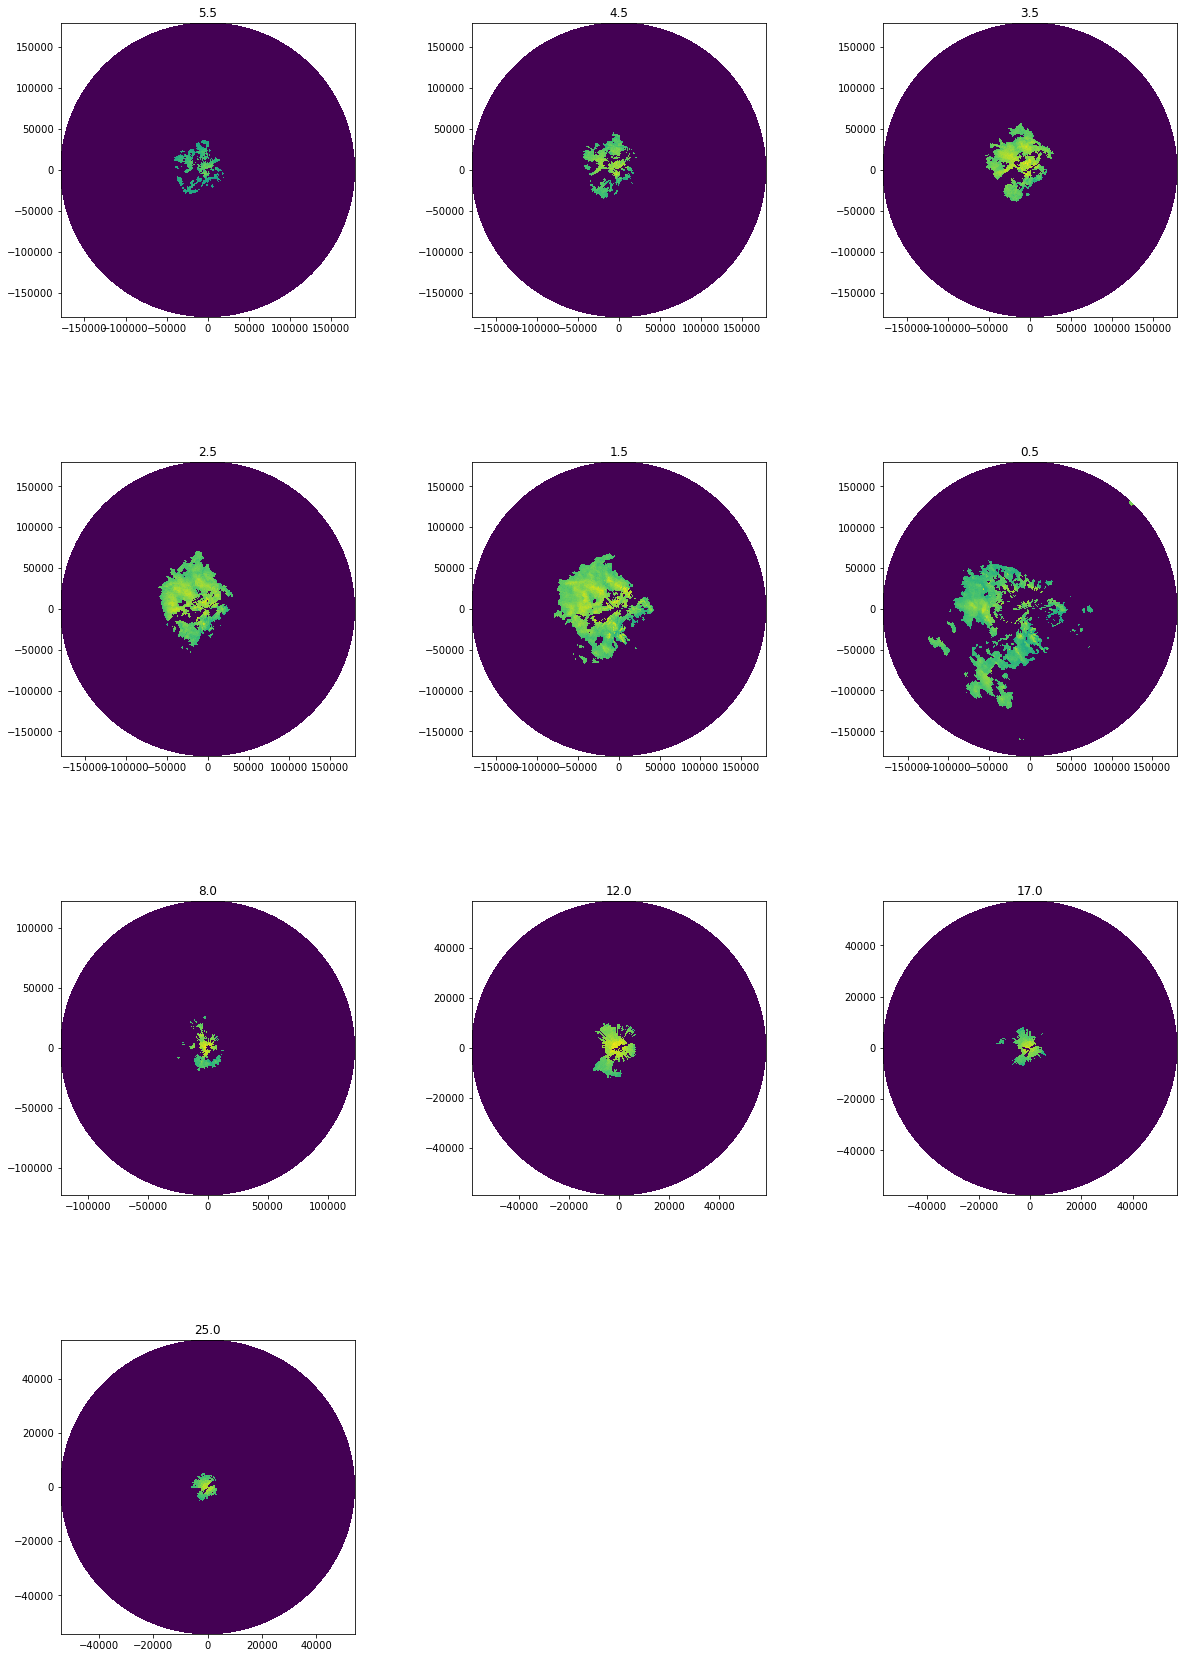

In [11]:
fig = pl.figure(figsize=(20, 30))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(4, 3, wspace=0.4, hspace=0.4)
for i, ts in enumerate(vol):
    swp = ts[0]
    swp.data.DBZH.pipe(wrl.georef.georeference_dataset).wradlib.plot(ax=gs[i], fig=fig)
    ax = pl.gca()
    ax.set_title(vol.root.sweep_fixed_angle[i].values)

### VRADH

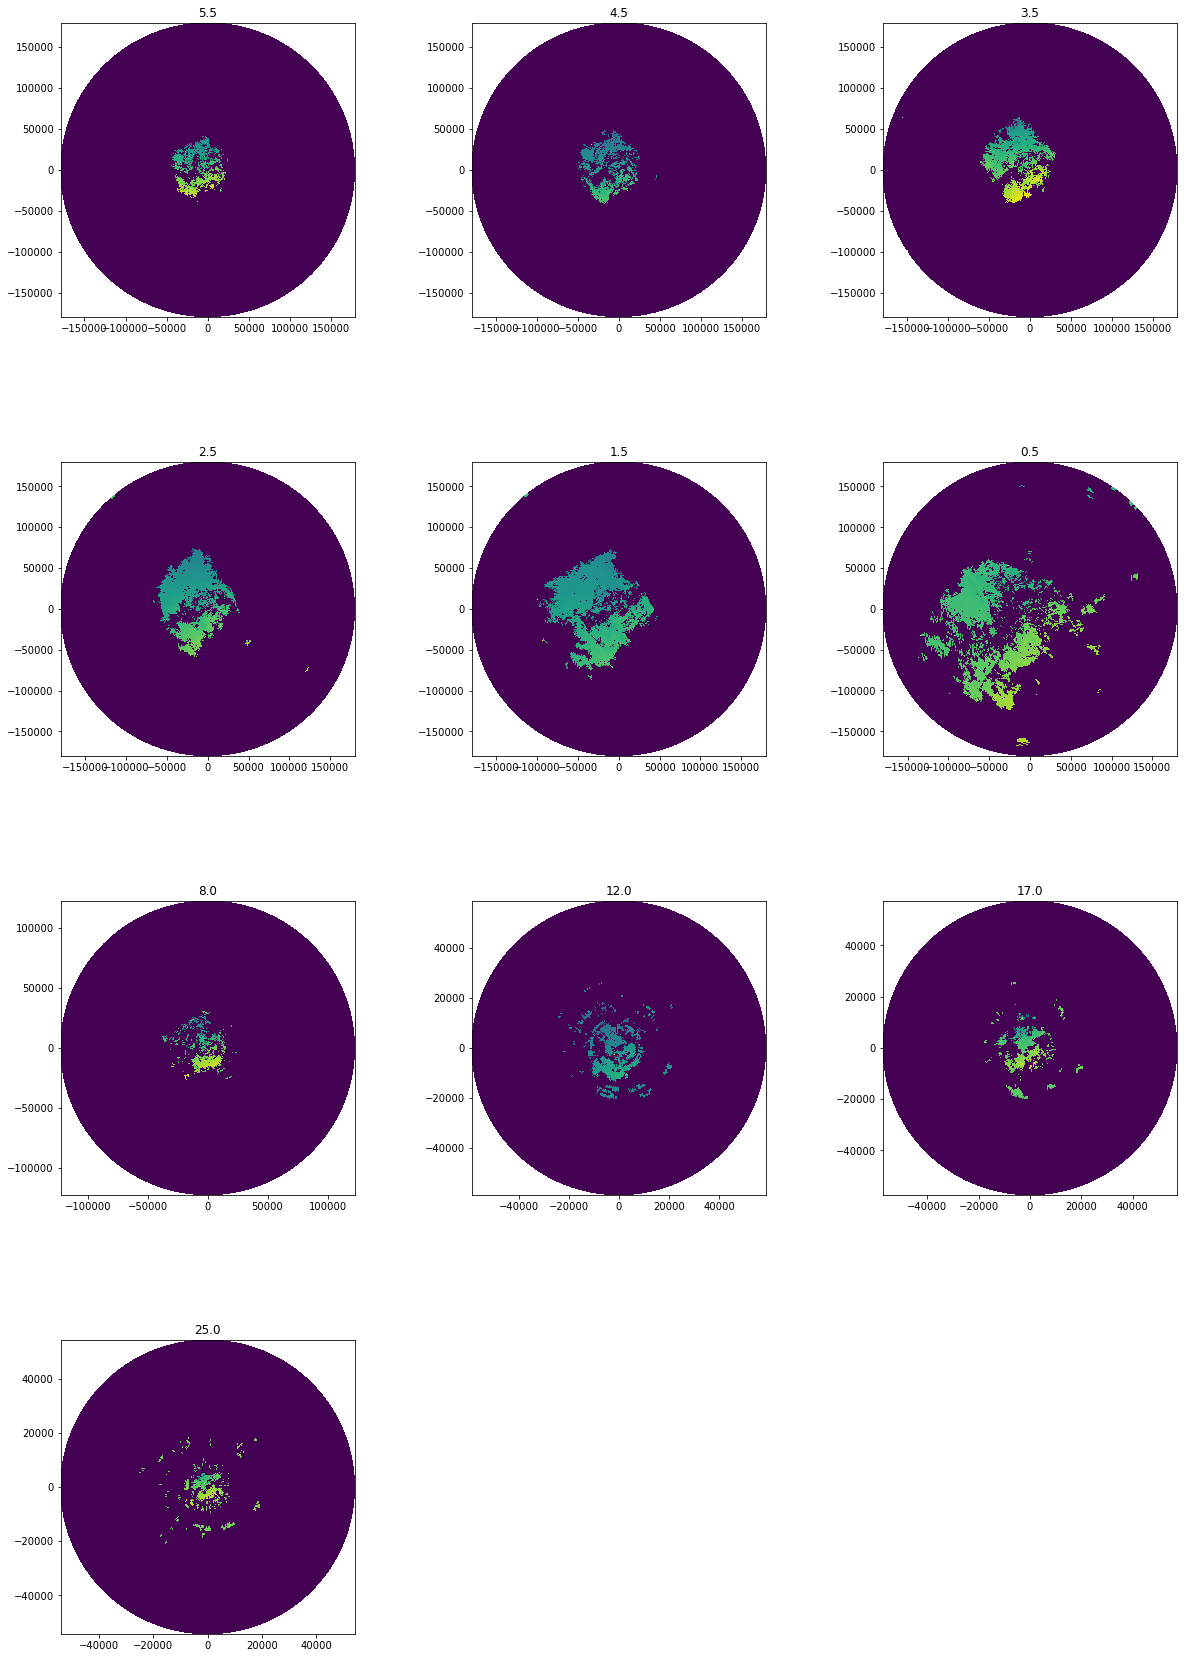

In [12]:
fig = pl.figure(figsize=(20, 30))
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(4, 3, wspace=0.4, hspace=0.4)
for i, ts in enumerate(vol):
    swp = ts[0]
    swp.data.VRADH.pipe(wrl.georef.georeference_dataset).wradlib.plot(ax=gs[i], fig=fig)
    ax = pl.gca()
    ax.set_title(vol.root.sweep_fixed_angle[i].values)

### Plot single sweep using cartopy

In [13]:
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

map_trans = ccrs.AzimuthalEquidistant(central_latitude=vol.root.latitude.values, 
                                      central_longitude=vol.root.longitude.values)

In [14]:
vol[-1].data

Collecting:   0%|          | 0/24 [00:00<?, ? Timesteps/s]

Collecting:  25%|██▌       | 6/24 [00:00<00:00, 53.68 Timesteps/s]

Collecting:  50%|█████     | 12/24 [00:00<00:00, 49.26 Timesteps/s]

Collecting:  71%|███████   | 17/24 [00:00<00:00, 47.64 Timesteps/s]

Collecting:  92%|█████████▏| 22/24 [00:00<00:00, 46.98 Timesteps/s]

Collecting: 100%|██████████| 24/24 [00:00<00:00, 47.78 Timesteps/s]

<xarray.Dataset>
Dimensions:     (azimuth: 360, range: 60, time: 24)
Coordinates:
  * azimuth     (azimuth) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * time        (time) datetime64[ns] 2021-01-08T12:43:50 ... 2021-01-08T14:3...
    elevation   (azimuth) float64 25.03 25.03 25.03 25.03 ... 25.03 25.03 25.03
    rtime       (time, azimuth) datetime64[ns] 2021-01-08T12:43:54.460999936 ...
  * range       (range) float32 500.0 1.5e+03 2.5e+03 ... 5.85e+04 5.95e+04
    sweep_mode  <U20 'azimuth_surveillance'
    latitude    float64 51.41
    longitude   float64 6.967
    altitude    float64 185.1
Data variables:
    DBZH        (time, azimuth, range) float32 7.748 8.194 4.083 ... -64.0 -64.0
    VRADH       (time, azimuth, range) float32 -32.27 -2.657 ... -32.27 -32.27

< GeoAxes: <cartopy.crs.AzimuthalEquidistant object at 0x7f8dd5076e00> >


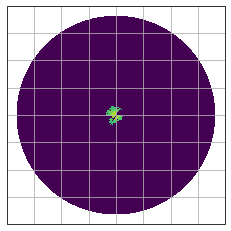

In [15]:
map_proj = ccrs.AzimuthalEquidistant(central_latitude=vol.root.latitude.values, 
                                      central_longitude=vol.root.longitude.values)
pm = vol[-1][0].data.pipe(wrl.georef.georeference_dataset).DBZH.wradlib.plot_ppi(proj=map_proj)
ax = pl.gca()
ax.gridlines(crs=map_proj)
print(ax)

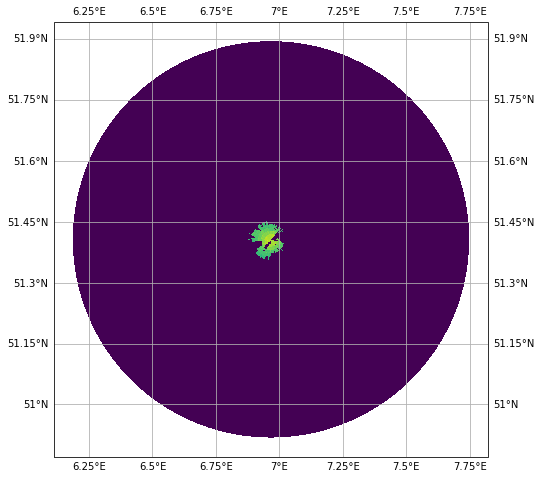

In [16]:
map_proj = ccrs.Mercator(central_longitude=vol.root.longitude.values)
fig = pl.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection=map_proj)
pm = vol[-1][0].data.pipe(wrl.georef.georeference_dataset).DBZH.wradlib.plot_ppi(ax=ax)
ax.gridlines(draw_labels=True)

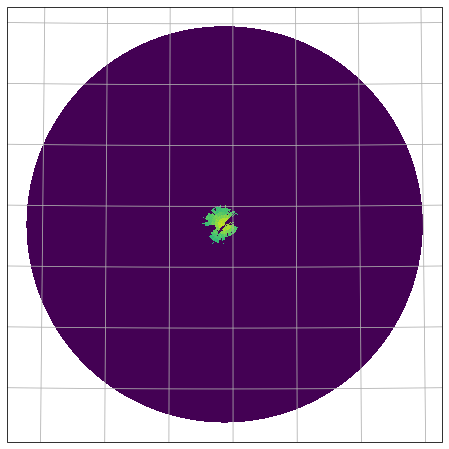

In [17]:
fig = pl.figure(figsize=(10, 8))
proj=ccrs.AzimuthalEquidistant(central_latitude=vol.root.latitude.values, 
                               central_longitude=vol.root.longitude.values)
ax = fig.add_subplot(111, projection=proj)
pm = vol[-1][0].data.DBZH.wradlib.plot_ppi(ax=ax)
ax.gridlines()

### Inspect radar moments

The dataarrays can be accessed by key or by attribute. Each dataarray has the datasets dimensions and coordinates of it's parent dataset. There are attributes connected which are defined by Cf/Radial and/or ODIM_H5 standard.

In [18]:
vol[-1][0].data.DBZH

<xarray.DataArray 'DBZH' (azimuth: 360, range: 60)>
array([[  7.748398,   8.193733,   4.083191, ..., -64.00293 , -64.00293 ,
        -64.00293 ],
       [  8.164436,   7.918335,   2.606567, ..., -64.00293 , -64.00293 ,
        -64.00293 ],
       [  7.765984,   8.372452,   1.979584, ..., -64.00293 , -64.00293 ,
        -64.00293 ],
       ...,
       [  8.375381,   9.45356 ,   1.68367 , ..., -64.00293 , -64.00293 ,
        -64.00293 ],
       [  8.199593,   7.722031,   2.955215, ..., -64.00293 , -64.00293 ,
        -64.00293 ],
       [  7.681015,   7.056961,   4.645721, ..., -64.00293 , -64.00293 ,
        -64.00293 ]], dtype=float32)
Coordinates:
  * azimuth     (azimuth) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
    time        datetime64[ns] ...
    elevation   (azimuth) float64 ...
    rtime       (azimuth) datetime64[ns] ...
  * range       (range) float32 500.0 1.5e+03 2.5e+03 ... 5.85e+04 5.95e+04
    sweep_mode  <U20 ...
    latitude    float64 ...
    longitude   float64 ...
    altitude    float64 ...
    x           (azimuth, range) float64 3.953 11.86 19.77 ... -461.2 -469.1
    y           (azimuth, range) float64 453.0 1.359e+03 ... 5.285e+04 5.375e+04
    z           (azimuth, range) float64 396.5 819.5 ... 2.51e+04 2.553e+04
    gr          (azimuth, range) float64 453.0 1.359e+03 ... 5.285e+04 5.375e+04
    rays        (azimuth, range) float64 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5
    bins        (azimuth, range) float32 500.0 1.5e+03 ... 5.85e+04 5.95e+04
Attributes:
    _Undetect:      0.0
    units:          dBZ
    standard_name:  radar_equivalent_reflectivity_factor_h
    long_name:      Equivalent reflectivity factor H

In [19]:
vol[-1][0].data.sweep_mode

<xarray.DataArray 'sweep_mode' ()>
array('azimuth_surveillance', dtype='<U20')
Coordinates:
    time        datetime64[ns] ...
    sweep_mode  <U20 ...
    latitude    float64 ...
    longitude   float64 ...
    altitude    float64 ...

In [20]:
vol.root

<xarray.Dataset>
Dimensions:              (sweep: 10)
Dimensions without coordinates: sweep
Data variables:
    volume_number        int64 0
    platform_type        <U5 'fixed'
    instrument_type      <U5 'radar'
    primary_axis         <U6 'axis_z'
    time_coverage_start  <U20 '2021-01-08T12:40:35Z'
    time_coverage_end    <U20 '2021-01-08T14:39:02Z'
    latitude             float64 51.41
    longitude            float64 6.967
    altitude             float64 185.1
    sweep_group_name     (sweep) <U7 'sweep_0' 'sweep_1' ... 'sweep_8' 'sweep_9'
    sweep_fixed_angle    (sweep) float64 5.5 4.5 3.5 2.5 ... 8.0 12.0 17.0 25.0
Attributes:
    version:          H5rad 2.2
    title:            None
    institution:      None
    references:       None
    source:           None
    history:          None
    comment:          im/exported using wradlib
    instrument_name:  None
    Conventions:      ODIM_H5/V2_2

# Plot Quasi Vertical Profile

In [21]:
vol

<wradlib.XRadVolume>
Dimension(s): (sweep: 10)
Elevation(s): (5.5, 4.5, 3.5, 2.5, 1.5, 0.5, 8.0, 12.0, 17.0, 25.0)

In [22]:
ts = vol[-1]
ts

<wradlib.XRadTimeSeries>
Dimension(s): (time: 24, azimuth: 360, range: 60)
Elevation(s): (25.0)

(0.0, 20000.0)

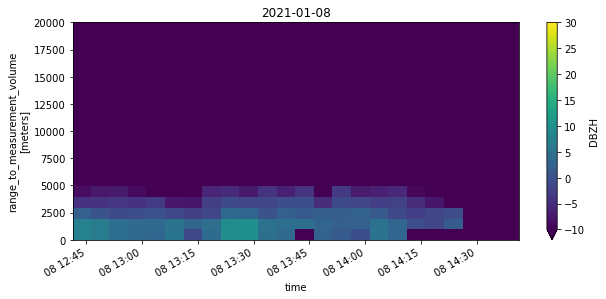

In [23]:
fig = pl.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
ts.data.DBZH.median('azimuth').plot(x='time', vmin=-10, vmax=30, ax=ax)
ax.set_title(f"{np.datetime_as_string(ts.data.time[0].values, unit='D')}")
ax.set_ylim(0, 20000)

## Export to OdimH5

This exports the radar volume at given timestep including all moments into one ODIM_H5 compliant data file.

In [24]:
vol.to_odim('dwd_odim.h5', timestep=0)

## Export to Cf/Radial2

This exports the radar volume at given timestep including all moments into one Cf/Radial2 compliant data file.

In [25]:
vol.to_cfradial2('dwd_cfradial2.nc', timestep=0)

## Import again and check equality

Small time differences are possible so drop times before comparison

In [26]:
try:
    vol1 = open_odim('dwd_odim.h5')
    vol2 = CfRadial('dwd_cfradial2.nc', dim0='azimuth')
    xr.testing.assert_equal(vol1.root, vol2.root)
    xr.testing.assert_equal(vol1[1][0].data.drop('time').rename({'rtime': 'time'}), vol2['sweep_1'])
    print("Equality Check successful")
except:
    print("Equality Check not successful")

Open:   0%|          | 0/1 [00:00<?, ? Files/s]

Open: 100%|██████████| 1/1 [00:00<00:00, 107.59 Files/s]


Collecting:   0%|          | 0/10 [00:00<?, ? Angles/s]

Collecting: 100%|██████████| 10/10 [00:00<00:00, 4920.00 Angles/s]

Equality Check not successful
